# Implementation of Probability Mass Function

In [1]:
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
import math 

In [2]:
def ensemble_error(n_classifier, error):

    k_start = int(math.ceil(n_classifier / 2.))
    probs = [
        (comb(n_classifier, k)) * error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier+1)
    ]

    return sum(probs)

In [3]:
ensemble_error(n_classifier=11, error=.25)

np.float64(0.03432750701904297)

In [4]:
error_range = np.arange(0.0, 1.01, .01)
ens_errors = [
    ensemble_error(n_classifier=11, error=error)
    for error in error_range
]

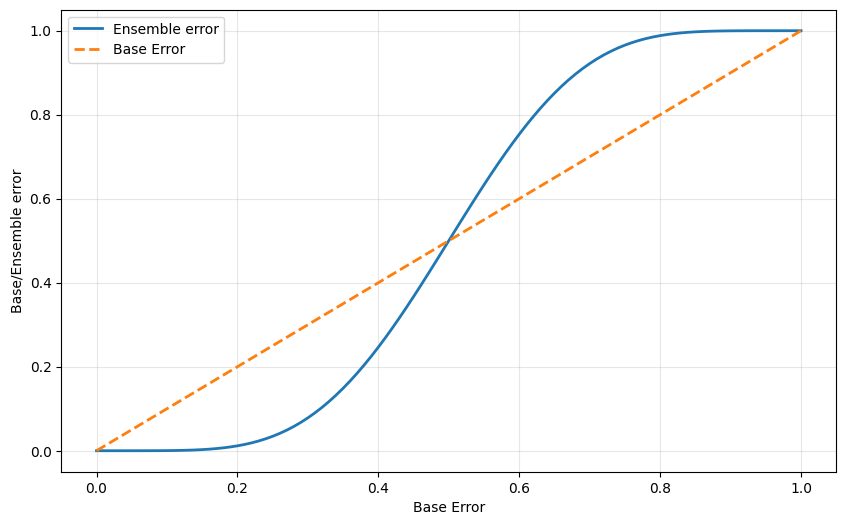

In [5]:
plt.figure(figsize=(10,6))
plt.plot(error_range, ens_errors, label="Ensemble error", linewidth=2)

plt.plot(error_range, error_range, linestyle='--', label='Base Error', linewidth=2)

plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(True, alpha=.3)
plt.show()

## Combining classifiers via majority vote

In [6]:
import numpy as np

In [7]:
np.argmax(np.bincount(
    [0,0,1],
    weights=[0.2, 0.2, 0.6]
))

np.int64(1)

In [8]:
# weighted majority vote based on class probabilities
ex = np.array(
    [
        [0.9, 0.1],
        [0.8, 0.2],
        [0.4, 0.6]
    ]
)

p = np.average(
    ex,
    axis=0,
    weights=[0.2, 0.2, 0.6]
)

p

array([0.58, 0.42])

In [9]:
np.argmax(p)

np.int64(0)

## Using the majority voting principle to make predictions

In [10]:
from scripts import MajorityVoteClassifier

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [12]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]

In [13]:
le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y
)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [16]:
clf1 = LogisticRegression(
    penalty='l2',
    C=0.001,
    solver='lbfgs',
    random_state=1
)

clf2 = DecisionTreeClassifier(
    max_depth=1,
    criterion='entropy',
    random_state=0
)

clf3 = KNeighborsClassifier(
    n_neighbors=1,
    p=2,
    metric='minkowski'
)

pipe1 = Pipeline(
    [
        ['sc', StandardScaler()],
        ['clf', clf1]
    ]
)

pipe3 = Pipeline(
    [
        ['sc', StandardScaler()],
        ['clf', clf3]
    ]
)

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']

print('=========== 10-fold cross validation ===========\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='roc_auc'
    )
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

=========== 10-fold cross validation ===========

ROC AUC: 0.92 (+/- 0.15) [LogisticRegression]
ROC AUC: 0.87 (+/- 0.18) [DecisionTree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [17]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)

clf_labels += ['MajorityVoting']
clf_labels

['LogisticRegression', 'DecisionTree', 'KNN', 'MajorityVoting']

In [18]:
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [19]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='accuracy'
    )
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.44 (+/- 0.08) [LogisticRegression]
ROC AUC: 0.86 (+/- 0.20) [DecisionTree]
ROC AUC: 0.84 (+/- 0.15) [KNN]
ROC AUC: 0.92 (+/- 0.13) [MajorityVoting]


## Evaluating and Tuning the ensemble classifier

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

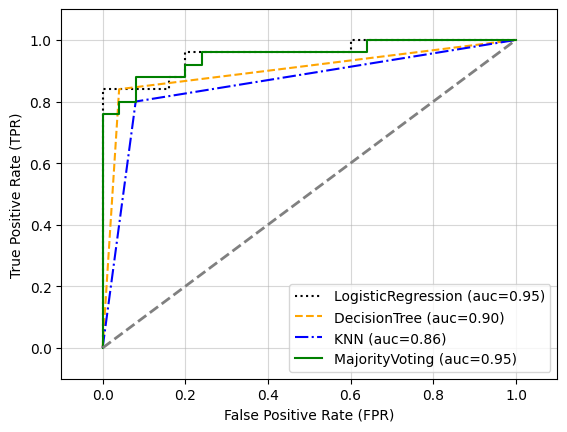

In [21]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(
        X_train,
        y_train
    ).predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(
        y_true=y_test,
        y_score=y_pred
    )

    roc_auc = auc(x=fpr, y=tpr)

    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc={roc_auc:.2f})')

plt.legend(loc='lower right')

plt.plot(
    [0,1],
    [0,1],
    linestyle='--',
    color='gray',
    linewidth=2
)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

In [22]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [23]:
from sklearn.model_selection import GridSearchCV

params = {
    'decisiontreeclassifier__max_depth': [1,2],
    'pipeline-1__clf__C': [0.001, 0.1, 100.0]
}

grid_model = GridSearchCV(
    estimator=mv_clf,
    param_grid=params,
    cv=10,
    scoring='accuracy'
)

In [24]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='accuracy')

In [25]:
print(f"{'-'*90}")
for r, _ in enumerate(grid_model.cv_results_['mean_test_score']):
    mean_score = grid_model.cv_results_['mean_test_score'][r]
    std_score = grid_model.cv_results_['std_test_score'][r]
    params = grid_model.cv_results_['params'][r]

    print(f'{mean_score:.3f} +/- {std_score:.2f} {params}')
print(f"{'-'*90}")
print(f'Best Parameters: {grid_model.best_params_}')
print(f"Accuracy: {grid_model.best_score_:.2f}")

------------------------------------------------------------------------------------------
0.920 +/- 0.13 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.940 +/- 0.09 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.900 +/- 0.18 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.920 +/- 0.13 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.940 +/- 0.09 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.900 +/- 0.18 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
------------------------------------------------------------------------------------------
Best Parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
Accuracy: 0.94


## Bagging - building an ensemble of classifiers from bootstrap samples

In [26]:
import pandas as pd

In [27]:
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
    )

In [28]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine.columns

Index(['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

In [29]:
df_wine = df_wine[df_wine['Class label'] != 1]

In [30]:
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [32]:
le = LabelEncoder()
y = le.fit_transform(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1,
    stratify=y
)

In [34]:
from sklearn.ensemble import BaggingClassifier

In [35]:
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    random_state=1,
    max_depth=None
)

In [36]:
bag_model = BaggingClassifier(
    estimator=tree_model,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1
)

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
tree = tree_model.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f"========== Decision Tree accuracies ==========")
print(f"Train Accuracy: {tree_train:.3f}")
print(f"Test Accuracy: {tree_test:.3f}")

========== Decision Tree accuracies ==========
Train Accuracy: 1.000
Test Accuracy: 0.833


In [39]:
bag = bag_model.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print(f"========== Bagging accuracies ==========")
print(f"Train Accuracy: {bag_train:.3f}")
print(f"Test Accuracy: {bag_test:.3f}")

========== Bagging accuracies ==========
Train Accuracy: 1.000
Test Accuracy: 0.917


## Leveraging weak learners via adaptive boosting

### Calculation of weighted error rate

In [40]:
import numpy as np

In [41]:
y = np.array([1,1,1,-1,-1,-1,1,1,1,-1])
yhat = np.array([1,1,1,-1,-1,-1,-1,-1,-1,-1])

In [42]:
correct=(y==yhat)
correct

array([ True,  True,  True,  True,  True,  True, False, False, False,
        True])

In [43]:
weights = np.full(10, 0.1)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [44]:
epsilon = np.mean(~correct)
epsilon

np.float64(0.3)

In [45]:
alpha_j = 0.5 * np.log((1-epsilon)/epsilon)
alpha_j

np.float64(0.42364893019360184)

In [46]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
update_if_correct

np.float64(0.06546536707079771)

In [47]:
update_if_wrong = 0.1 * np.exp(-alpha_j*1*-1)
update_if_wrong

np.float64(0.1527525231651947)

In [48]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong)

In [49]:
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [50]:
normalized_weights = weights / np.sum(weights)

In [51]:
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


### Applying AdaBoost using scikit-learn

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [53]:
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    random_state=1,
    max_depth=1
)

In [54]:
ada_model = AdaBoostClassifier(
    estimator=tree_model,
    n_estimators=500,
    learning_rate=0.1,
    random_state=1
)

In [55]:
tree_model.fit(X_train, y_train)
y_train_pred_tree = tree_model.predict(X_train)
y_test_pred_tree = tree_model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred_tree)
accuracy_test = accuracy_score(y_test, y_test_pred_tree)

print(f"=========== Decision tree accuracies ===========")
print(f"Accuracy Train: {accuracy_train:.3f}\nAccuracy Test: {accuracy_test:.3f}")

=========== Decision tree accuracies ===========
Accuracy Train: 0.916
Accuracy Test: 0.875


In [56]:
ada_model.fit(X_train, y_train)
y_train_pred_ada = ada_model.predict(X_train)
y_test_pred_ada = ada_model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred_ada)
accuracy_test = accuracy_score(y_test, y_test_pred_ada)

print(f"=========== AdaBoost accuracies ===========")
print(f"Accuracy Train: {accuracy_train:.3f}\nAccuracy Test: {accuracy_test:.3f}")

=========== AdaBoost accuracies ===========
Accuracy Train: 0.968
Accuracy Test: 0.917


### Gradient boosting using XGBoost

In [57]:
from xgboost import XGBClassifier

In [58]:
model_xgboost = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    random_state=1,
    use_label_encoder=False
)

In [60]:
model_xgboost.fit(X_train, y_train)
y_train_pred = model_xgboost.predict(X_train)
y_test_pred = model_xgboost.predict(X_test)

/home/francisco/Documentos/machine-learning-for-developers/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:27:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [62]:
model_xgboost_train = accuracy_score(y_train, y_train_pred)
model_xgboost_test = accuracy_score(y_test, y_test_pred)

print(f"=========== XGBoost accuracies ===========")
print(f"Accuracy Train: {model_xgboost_train:.3f}\nAccuracy Test: {model_xgboost_test:.3f}")

=========== XGBoost accuracies ===========
Accuracy Train: 0.968
Accuracy Test: 0.917
